# NLP-Sentiment Analysis for Financial News 

Dataset url: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news?select=all-data.csv

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import time
nltk.download('vader_lexicon') 
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/noofas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noofas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/noofas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/noofas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Read Dataset
data = pd.read_csv('all-data.csv',encoding="latin1",header=None)
data.columns = ["Label","Text"]
data.head()

,Label,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [3]:
#check whether are there any missing value or not
data.isnull().sum()

Label    0
Text     0
dtype: int64

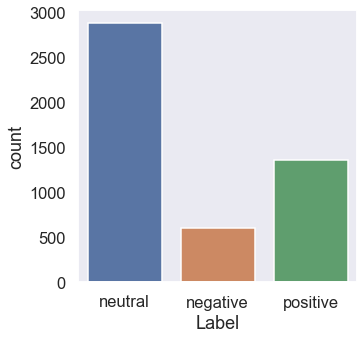

In [47]:
#check whether the dataset is balanced or unbalanced
plt.subplots(figsize=(5,5))
sns.countplot(data["Label"])
plt.show()

#### Dataset is unbalanced, most of the dataset is neutral as we can predict.

In [5]:
data["Label"].value_counts()

neutral     2879
positive    1363
negative     604
Name: Label, dtype: int64

In [6]:
#the lenghts by class
data["len"] = [len(text) for text in data["Text"].values]

data.groupby("Label")["len"].mean()

Label
negative    125.756623
neutral     125.072247
positive    135.647836
Name: len, dtype: float64

## Cleaning Texts

In [7]:
def cleanText(text):
    
    lemma = WordNetLemmatizer()
    stp = stopwords.words('english')
    
    # This means remove everything except emojis, alphabetical and numerical characters
    text = re.sub("[^a-zA-Z_#@\s\U00010000-\U0010ffff]"," ",text)
    
    text = text.lower()
    
    # This mean split sentences by words ("I am good" => ["I","am","good"])
    text = nltk.word_tokenize(text)
    
    # Lemmatizers convert words to their base form using dictionaries (going => go, bees => be , dog => dog)
    text = [lemma.lemmatize(word) for word in text]
    
    # We should remove stopwords, stopwords are the words that has no special meaning such as I,You,Me,Was
    text = [word for word in text if word not in stp]
    
    # Everything is ready, now we just need join the elements of lists (["feel","good"] => "feel good")
    text = " ".join(text)
    
    return text

In [8]:
#Test cleanText Function
cleanText("Nowadays I am interested in traditional text feature extraction methods, because I want to learn foundations")

'nowadays interested traditional text feature extraction method want learn foundation'

In [9]:
start_time = time.time()
cleanedText = []
for text in data["Text"]:
    
    cleanedText.append(cleanText(text))
end_time = time.time()
process_time = round(end_time-start_time,2)

print("="*10)
print("Texts are cleaned, this process took {} seconds \n \n".format(process_time))

print(cleanedText[0])

Texts are cleaned, this process took 2.22 seconds 
 

according gran company ha plan move production russia although company growing


In [10]:
#Convert categorical to Numarical
y = []
for label in data["Label"]:
    
    if label=="negative":
        y.append(0)
        
    elif label=="positive":
        y.append(2)
        
    elif label=="neutral":
        y.append(1)

y = np.asarray(y)

In [11]:
data

,Label,Text,len
0,neutral,"According to Gran , the company has no plans t...",127
1,neutral,Technopolis plans to develop in stages an area...,190
2,negative,The international electronic industry company ...,228
3,positive,With the new production plant the company woul...,206
4,positive,According to the company 's updated strategy f...,203
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,144
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,148
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,108
4844,negative,Net sales of the Paper segment decreased to EU...,226


## TF-IDF Vectorizing

In [12]:
# First, we need a vectorizer object
vectorizer = TfidfVectorizer(max_features=4000)
# This means just consider most used 4000 words

start = time.time()

x = vectorizer.fit_transform(cleanedText).toarray()

process_time = round(time.time()-start,2)

print("Vectorizing cleaned text using TF-IDF approach took {} seconds".format(process_time))

x.shape

Vectorizing cleaned text using TF-IDF approach took 0.22 seconds


(4846, 4000)

In [13]:
#Splitting features/target and train/test data
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42,test_size=0.2)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3876, 4000)
(970, 4000)
(3876,)
(970,)


## Building Classifiers

In [14]:
#using Piplaine
models = {
    MultinomialNB():'Multinomial Naive Bayes',
    LogisticRegression(max_iter=300):'Logistic Regression',
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=100):"AdaBoostClassifier"
}
for m in models.keys():
    m.fit(x_train,y_train)

In [15]:
# Check Accuracy for each model
for model,name in models.items():
     print(f"Accuracy Score for {name} is : ",model.score(x_test,y_test)*100,"%")

Accuracy Score for Multinomial Naive Bayes is :  68.76288659793815 %
Accuracy Score for Logistic Regression is :  74.5360824742268 %
Accuracy Score for AdaBoostClassifier is :  70.82474226804123 %


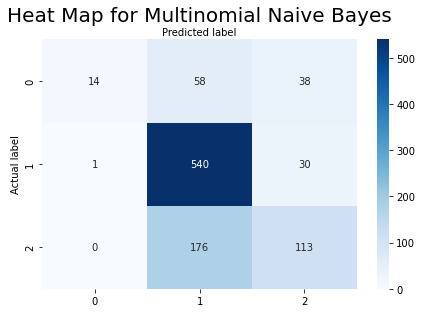

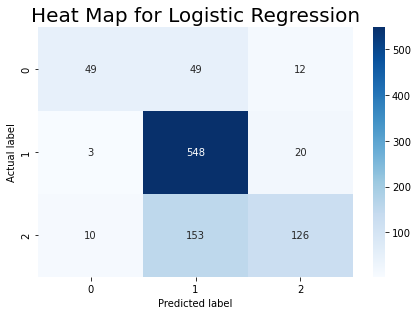

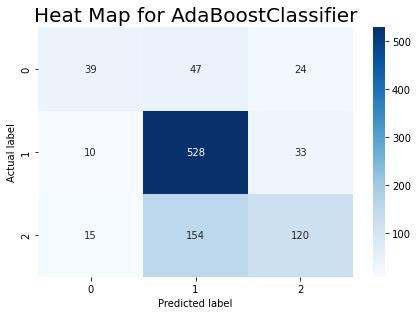

In [41]:
# Plot Heatmaps for all models

class_names = [0,1]
fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)


for model,name in models.items():
    y_pred = model.predict(x_test)
    cnf_matrix = confusion_matrix(y_test,y_pred)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'Blues',
            fmt = 'g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title(f'Heat Map for {name}', {'fontsize':20})
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

## Use the best Classifier: LogisticRegression

In [17]:
class_sv=LogisticRegression(max_iter=300)
class_sv.fit(x_train, y_train)

LogisticRegression(max_iter=300)

In [18]:
#accuracy
y_pred = class_sv.predict(x_test)

print("Test set accuracy of our LogisticRegression Classifier is {}".format(round(accuracy_score(y_pred,y_test)*100,2)))

Test set accuracy of our LogisticRegression Classifier is 74.54


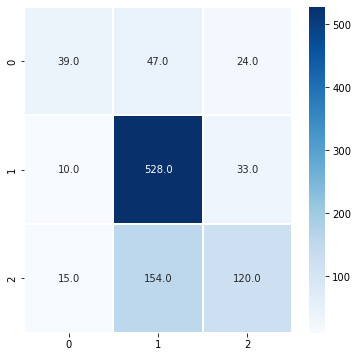

In [42]:
#plot confusion_matrix
plt.subplots(figsize=(6,6))
sns.heatmap(confusion_matrix(y_pred=y_pred,y_true=y_test),annot=True,fmt=".1f",linewidths=1.5,cmap="Blues")
plt.show()

## Saving best Model 

In [20]:
pickle.dump(class_sv,open("class_sv.pickle","wb"))
pickle.dump(vectorizer,open("vectorizer.pickle","wb"))

In [37]:
def analyseText(text):
    
    cls = pickle.load(open("class_sv.pickle","rb"))
    vct = pickle.load(open("vectorizer.pickle","rb"))
    
    # First we need to clean the text given
    text = cleanText(text)
    
    # Then we need to vectorize the text
    text = vct.transform([text])
    
    # And let's predict results using vector
    pred = cls.predict(text)
    if pred[0] == 0:
        decision = "negative"
    
    elif pred[0] == 1:
        decision = "neutral"
        
    elif pred[0] == 2:
        decision = "positive"
        
    return decision

## Check Result

In [38]:
analyseText("Rental of building equipment accounted for 88 percent of the operating income ")

'neutral'

In [39]:
analyseText("O'Leary 's Material Handling Services , located in Perth , is the leading company in Western Australia that supplies , installs and provides service for tail lifts .")

'positive'

In [40]:
analyseText(" he international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported negative ")

'negative'